# Local Graph Clustering with Network Lasso 
## Numerical Experiments
### A. Jung (Aalto University, Finland)

In [1]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import networkx as nx 
import localgraphclustering as lgc 

The code block below implements a local cluster algorithm using the primal-dual updates described in Section IV [1] for iteratively solving the nLasso problem in [1].

[1] A. Jung, "Local Graph Clustering with Network Lasso", under preparation, 2020.  

In [2]:
def locclustnlasso (GWeighted,alpha,lambda_nLasso,samplingset,nriter): 

    nrnodes = len(list(GWeighted.nodes))  # number of nodes in graph 
    nredges = len(list(GWeighted.edges))  # number of edges in directed weighted empiricial graph 
    
    B = nx.incidence_matrix(GWeighted,oriented=True)  # construct incidence matrix 
    B = B.transpose()                                 # rows of B represent edges, cols of B represent nodes

    Lambda = 1*np.diag(1./(np.sum(abs(B), 1)))
    Gamma_vec = (1./(np.sum(abs(B), 0))).T  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    weight_vec = np.zeros((nredges,1))
    cntr=0
    for edge in GWeighted.edges(data='weight'): 
        weight_vec[cntr] = edge[2]
        cntr=cntr+1

    weight = np.diag(weight_vec)


    D = np.dot(weight, B)
    primSLP = np.ones((nrnodes,1))
#primSLP[N-1] = 0
    dualSLP = np.zeros((nredges,1)) # array([x/(N-1) for x in range(1, N)])

    hatx = np.zeros((nrnodes,1))     # numpy array for storing current iterate for nLasso solution
    prevx = np.zeros((nrnodes,1))    # numpy array for storing previous iterate
    haty = np.zeros((nredges,1))     # numpy array for storing current iterate for dual solution 
    newx = 0*hatx                    # numpy array for intermediate results 


    seednodesindicator= np.zeros((nrnodes,1))
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones((nrnodes,1))
    noseednodeindicator[samplingset] = 0
    
    running_average = 0*hatx
   # running_averagey = 0*hatx


    log_conv= np.zeros((nriter,1))
   # log_bound= np.zeros((nriter,1))
   

    hist_y = np.zeros((nriter, nredges))
    hist_x = np.zeros((nriter, nrnodes))


    fac_alpha = np.zeros((len(Gamma_vec),1))
    for cntr in range(len(Gamma_vec)): 
        fac_alpha[cntr] = 1/(Gamma_vec[cntr]*alpha+1)  # \in [0, 1]

    print(haty.shape)

    for iterk in range(nriter):
    # tildex = 2 * newx - hatx
        tildex = 2 * hatx - prevx
        newy = haty + (1 / 2) * (B@tildex)  # chould be negative
    
        haty = np.clip(newy, -(lambda_nLasso * weight_vec), (lambda_nLasso * weight_vec))
    #haty = np.copy(newy)
  
   # newx = hatx - Gamma_vec @ (B.T @ haty)  # could  be negative
        newx1 = hatx -  np.multiply(Gamma_vec,(B.T @ haty))  # could  be negative
        newx2 = np.copy(newx1)
        for dmy in range(len(samplingset)):
            idx_dmy = samplingset[dmy]
            newx2[idx_dmy] = (newx1[idx_dmy] + Gamma_vec[idx_dmy]) / (1 + Gamma_vec[idx_dmy])

        newx = np.multiply(seednodesindicator,newx2) + np.multiply(noseednodeindicator ,np.multiply(newx1, fac_alpha))
        prevx = np.copy(hatx)
        hatx = newx  # could be negative

    #hist_y[iterk, :] = haty[:,0]
    #hist_x[iterk, :] = hatx[:,0]

        running_average = (running_average * iterk + hatx) / (iterk + 1)
   # dual = np.sign(B@running_average)

   # dual[iterk:(N - 1)] = 0

        log_conv[iterk] = sum(abs(B@running_average))
    #log_bound[iterk] = (1 / (2 * (iterk+1))) * (np.dot(primSLP.T, np.linalg.inv(Gamma)).dot(primSLP))+(np.dot((dualSLP-dual).T, np.linalg.inv(Lambda)).dot(dualSLP - dual))
    return running_average

## Grid Graphs - Images

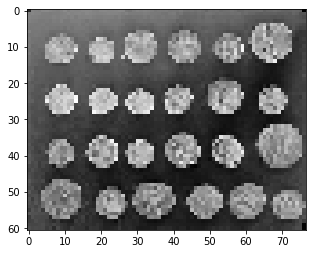

In [16]:

orig_coins = coins()                   # read in coins image 
coin_img = orig_coins[0:-1:5,0:-1:5]  # subsample image 

# Plot the results on an image
plt.figure(figsize=(5, 10))
plt.imshow(coin_img, cmap=plt.cm.gray)
plt.show()

shape_img = coin_img.shape    # determine nr of rows and cols of image 


# define a grid graph to represent the image pixels 
Gcoins = nx.grid_2d_graph(shape_img[0],shape_img[1])
    
# construct a directed graph by oriented the edges of G 
GWeightedcoins = nx.DiGraph() 

for edge in Gcoins.edges: 
    node1 = edge[0]
    node2 = edge[1]
    # read in grayscale values of pixels connected by edge 
    val1 = float(coin_img[node1])   
    val2 = float(coin_img[node2])
    # determine edge weight based on difference in grayscale values
    weight1= np.exp(-((val1-val2)/20)**2)       
    GWeightedcoins.add_edge(node1,node2,weight=weight1)
    

# network visualization 

#posgrid={}
#for nodei in Gcoins.nodes: 
#    xy = list(nodei)
#    posgrid.update({nodei:10*np.array(xy)})   
#options = {"node_color": "C0", "node_size": 3}
#plt.figure(figsize=(20, 20))
#nx.draw_networkx(GWeighted, posgrid,with_labels=False)
#for edge in GWeighted.edges(data='weight'):
#    nx.draw_networkx_edges(GWeighted, posgrid, edgelist=[edge], width=6*edge[2])



Choose seed nodes around which we aim to find a local cluster. The indices of the seed nodes are stored in the list `samplingset`. We indicate the seednodes by adding red contours on top of the image. 

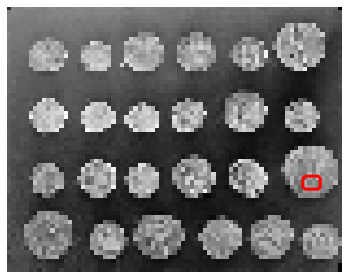

In [103]:
nodelist = list(Gcoins.nodes)


seednodes =[]   # store seed nodes as pairs (row,col)
samplingset=[]  # store seed nodes as linear index 

for row in range(39,42): 
    for col in range(68,72):
        nodedmy = (row,col)
        seednodes.append(nodedmy)
        samplingset.append(nodelist.index(nodedmy))
        
#coinseed = [nodelist.index(40,70),nodelist.index(41,70)
#pixel1 = nodelist.index(coinseed)
#samplingset = [pixel1]

seednodesindicator = 0*coin_img.copy()

for nodedmy in seednodes : 
    seednodesindicator[nodedmy] = 1 

# Plot the results on an image
fig,ax = plt.subplots(figsize=(6,10))
ax.imshow(coin_img, cmap=plt.cm.gray)
ax.contour(seednodesindicator, levels=[0.5],colors='r',linewidths=[3])
plt.axis('off')
plt.savefig('CoinsSeedNodes.png',bbox_inches='tight', pad_inches=0)
plt.show()



The code block below implements a local cluster method using the updates (??) - (??) to iteratively solve the nLasso problem (??). 

In [104]:
import numpy as np
import time 

start = time.time()

alpha = 1/10
alpha = 1/10000
lambda_nLasso = 1/3  # nLasso parameter
lambda_nLasso = 3/10
lambda_nLasso = 2/10
nriter = 1000
xhat = locclustnlasso(GWeightedcoins,alpha,lambda_nLasso,samplingset,nriter)

(9256, 1)


/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



<StemContainer object of 3 artists>

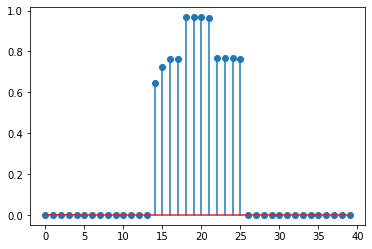

In [105]:
sig = xhat[(pixel1-20):(pixel1+20)]
plt.stem(range(len(sig)),sig)

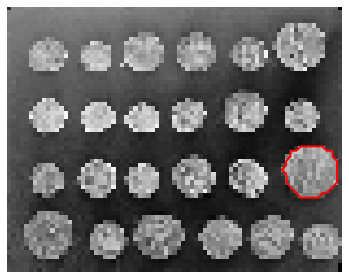

In [106]:
clusteringsig = np.zeros((shape_img[0],shape_img[1]))
cntr = 0 
for node in GWeightedcoins.nodes: 
    clusteringsig[node[0],node[1]] = xhat[cntr]
    cntr = cntr+1
    
    
# Plot the results on an image
fig,ax = plt.subplots(figsize=(6,10))
ax.imshow(coin_img, cmap=plt.cm.gray)
ax.contour(clusteringsig, levels=[0.5],colors='r',linewidths=[2])
plt.axis('off')
plt.savefig('CoinsNLasso.png',bbox_inches='tight', pad_inches=0)
plt.show()


The code snippets below apply the local clustering methods provided at  
https://github.com/kfoynt/LocalGraphClustering 
to the image segmentation task above. 
    

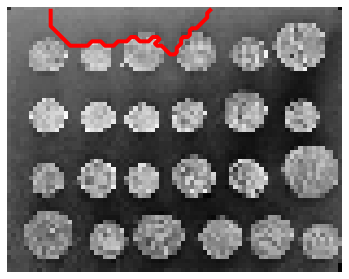

In [107]:
seed = seednodes
Glgc = lgc.GraphLocal.from_networkx(GWeightedcoins.to_undirected())
acl = lgc.approximate_PageRank_weighted(Glgc,seed)


xhat1 = np.zeros((len(list(GWeightedcoins.nodes)),1) )

clusterout = acl[0]
for nodei in clusterout:
    xhat1[nodei] = 1

clusteringsig = np.zeros((shape_img[0],shape_img[1]))
cntr = 0 
for node in GWeightedcoins.nodes: 
    clusteringsig[node[0],node[1]] = xhat1[cntr]
    cntr = cntr+1
    
# Plot the results on an image
fig,ax = plt.subplots(figsize=(6,10))
ax.imshow(coin_img, cmap=plt.cm.gray)
ax.contour(clusteringsig, levels=[0.5],colors='r',linewidths=[4])
plt.axis('off')
plt.savefig('CoinsApproxPR.png',bbox_inches='tight', pad_inches=0)
plt.show()

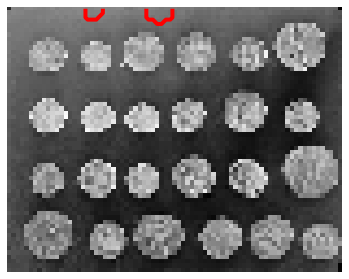

In [108]:
seed = seednodes
#Glgc = lgc.GraphLocal.from_networkx(GWeightedcoins.to_undirected())
acl = lgc. capacity_releasing_diffusion(Glgc,seed)


xhat1 = np.zeros((len(list(GWeightedcoins.nodes)),1) )

clusterout = acl[0]
for nodei in clusterout:
    xhat1[nodei] = 1

clusteringsig = np.zeros((shape_img[0],shape_img[1]))
cntr = 0 
for node in GWeightedcoins.nodes: 
    clusteringsig[node[0],node[1]] = xhat1[cntr]
    cntr = cntr+1
    
# Plot the results on an image
fig,ax = plt.subplots(figsize=(6,10))
ax.imshow(coin_img, cmap=plt.cm.gray)
ax.contour(clusteringsig, levels=[0.5],colors='r',linewidths=[4])
plt.axis('off')
plt.savefig('CoinsCapacityReleasing.png',bbox_inches='tight', pad_inches=0)
plt.show()

/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/localgraphclustering/spectral_clustering.py:111: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.

/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:123: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted or l1reg-rand instead if you want to keep the edge weights.

/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py:70: UserWarning:

The weights of the graph will be discarded. Use "crd" or "mqi_weighted" if you want to keep them.



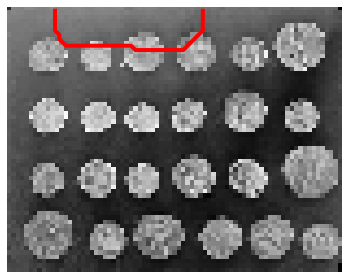

In [109]:
Sacl,condacl = lgc.spectral_clustering(Glgc,seednodes,method="acl") # one step
Smqi,condmqi = lgc.flow_clustering(Glgc,Sacl,method="mqi")

xhat1 = np.zeros((len(list(GWeightedcoins.nodes)),1) )

clusterout = Smqi
for nodei in clusterout:
    xhat1[nodei] = 1

clusteringsig = np.zeros((shape_img[0],shape_img[1]))
cntr = 0 
for node in GWeightedcoins.nodes: 
    clusteringsig[node[0],node[1]] = xhat1[cntr]
    cntr = cntr+1
    
# Plot the results on an image
fig,ax = plt.subplots(figsize=(6,10))
ax.imshow(coin_img, cmap=plt.cm.gray)
ax.contour(clusteringsig, levels=[0.5],colors='r',linewidths=[4])
plt.axis('off')
plt.savefig('CoinsMQI.png',bbox_inches='tight', pad_inches=0)

plt.show()

## Chain Graph Experiments

In what follows we apply nLasso for local graph clustering in a chain graph. 

/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



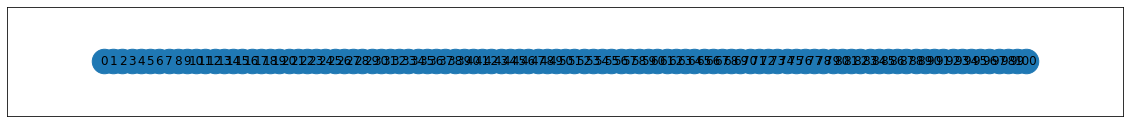

In [110]:
GWeighted = nx.DiGraph() 
lenchain = 100   #nr of nodes in the chain 

boundary = 4    # 4th node is the boundary of local cluster
GWeighted.add_nodes_from(range(lenchain))

for iterdmy in range(boundary-1):
    GWeighted.add_edge(iterdmy,iterdmy+1,weight=5/4)

GWeighted.add_edge(boundary-1,boundary,weight=1)

for iterdmy in np.arange(boundary,lenchain): 
    GWeighted.add_edge(iterdmy,iterdmy+1,weight=5/4)

options = {"node_color": "C0", "node_size": 6}
plt.figure(figsize=(20, 2))

posgrid={}
for nodei in GWeighted.nodes: 
    posgrid.update({nodei:(nodei,0)})
    
#nodpos = np.hstack(np.reshape(np.arange(0,lenchain),lenchain,-1),np.zeros(lenchain,1))

nx.draw_networkx(GWeighted,posgrid,node_size=600)

for edge in GWeighted.edges(data='weight'):
    nx.draw_networkx_edges(GWeighted,posgrid,edgelist=[edge], width=2*edge[2])


In [10]:
lambda_nLasso = 1/3  # nLasso parameter
lambda_nLasso = 2/10
nriter = 1000
samplingset =[0]
alpha=1/200

xhat = locclustnlasso(GWeighted,alpha,lambda_nLasso,samplingset,nriter)

(100, 1)


/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



(10, 1)
(10, 1)


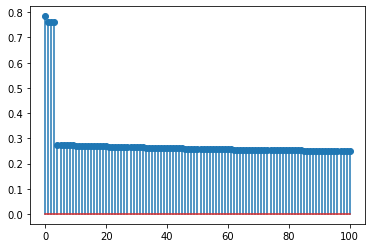

In [11]:
plt.stem(range(len(xhat)),xhat)
nodeidx = range(10) 
xhat = xhat[nodeidx]

nodeidx = np.array(nodeidx)+1
nodeidx = nodeidx.reshape(-1,1)
print(nodeidx.shape)

xhat    = xhat.reshape(-1,1)
print(xhat.shape)

mtx = np.hstack((nodeidx,xhat)) 
np.savetxt("nLassoChain.csv", mtx, fmt='%2.3e', delimiter=',', comments ='',newline='\n', header='i,x', footer='', encoding=None)

In [12]:
G = lgc.GraphLocal.from_networkx(GWeighted.to_undirected())

In [13]:
f = lgc.fiedler(G)

In [14]:
print(type(f))

<class 'tuple'>


(10, 1)
(10, 1)


/Users/alexanderjung/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



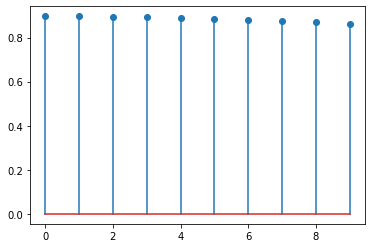

In [15]:
xhatspec = f[0]

nodeidx = range(10) 
xhatspec = 10*xhatspec[nodeidx]

nodeidx = np.array(nodeidx)+1
nodeidx = nodeidx.reshape(-1,1)
print(nodeidx.shape)

xhatspec    = xhatspec.reshape(-1,1)
print(xhatspec.shape)
mtx1 = np.hstack((nodeidx,xhatspec)) 
plt.stem(range(len(xhatspec)),xhatspec)
np.savetxt("FiedlerChain.csv", mtx1, fmt='%2.3e', delimiter=',', comments ='',newline='\n', header='i,x', footer='', encoding=None)